In [ ]:
# # ONLY RUN WHEN IN GOOGLE COLAB

# !git clone https://github.com/Vachonni/TrainingNLP.git

# import os
# os.chdir('TrainingNLP')

# !pip install -r requirements_colab.txt
# !pip install -e .

In [1]:
# # ONLY RUN WHEN IN AZURE
# import os
# os.chdir('..')

# !pip install -r requirements.txt
# !pip install -e .

  Using cached peft-0.7.1-py3-none-any.whl (168 kB)
ERROR: peft 0.7.1 has requirement huggingface-hub>=0.17.0, but you'll have huggingface-hub 0.14.1 which is incompatible.
Obtaining file:///mnt/batch/tasks/shared/LS_root/mounts/clusters/tigpu/code/Users/nicholas.vachon/TrainingNLP
  Attempting uninstall: TrainingNLP
    Found existing installation: TrainingNLP 0.0.1
    Uninstalling TrainingNLP-0.0.1:
      Successfully uninstalled TrainingNLP-0.0.1
  Running setup.py develop for TrainingNLP


In [2]:
import os
import torch

import pandas as pd

from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    Trainer, 
    TrainingArguments, 
    EarlyStoppingCallback, 
)
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score, f1_score
from peft import LoraConfig, get_peft_model

import config

# Print data example with complete content of column 'review'
pd.set_option('display.max_colwidth', None)

# **Consort - Formation NLP**

## Introduction - Analyse de sentiments

Objectif: Déterminer le sentiment d'un texte à l'aide de différentes techniques.

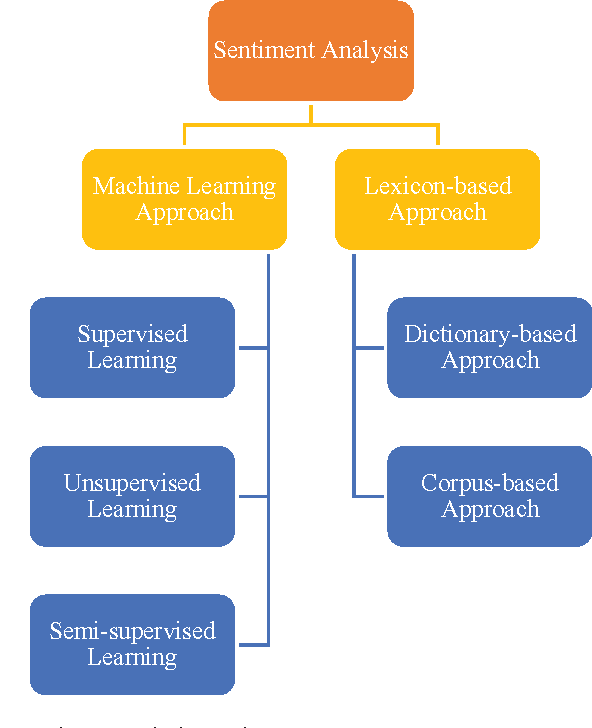






### Approche lexicale 
(*Lexicon or Rule-Based approach*)
  - RegEx
  - NLTK
  - SpaCy

### Machine Learning
  - Modèles à taille fixe
    - Bag of words
  - Modèles réccurents
    - CBOW
  - Modèles transformeurs
    - À affiner (fine-tune)
    - HuggingFace Sentiment Analysis
    - Google's API (sans création de compte)



# Données

Jeu de données pour l'analyse de sentiments: Avis des utilisateurs d'Allociné.fr disponible ici: https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/tree/master/allocine_dataset

Il contient 100 000 avis positifs et 100 000 avis négatifs répartis en 3 répartitions équilibrées : train (160 000 avis), val (20 000) et test (20 000).

**NOTE:** Afin d'optimiser le temps de calcul pour cet exercice, nous allons réduire l'ensemble test 1000. 

In [3]:
# Load data
train_data = pd.read_csv(config.base_dir + '/Data/train_data.csv', usecols=['review', 'polarity'])
val_data = pd.read_csv(config.base_dir + '/Data/val_data.csv', usecols=['review', 'polarity'])
test_data = pd.read_csv(config.base_dir + '/Data/prepro_test_data.csv', usecols=['review', 'polarity'])


## Préparation des données pour les transformers de HuggingFace

### datasets.Dataset

Pour la classification de texte, les modèles de HuggingFace requièrent des noms de colonnes spécifiques: `text` et `label`.

Ensuite, les données doivent être converties en un objet `Dataset` de HuggingFace.

In [4]:
# Transform data to fit HuggingFace datasets
def transform_to_dataset(data: pd.DataFrame) -> Dataset:
    dataset = Dataset.from_pandas(data)
    dataset = dataset.rename_column("review", "text")
    dataset = dataset.rename_column("polarity", "label")
    return dataset

train_dataset = transform_to_dataset(train_data)
val_dataset = transform_to_dataset(val_data)
test_dataset = transform_to_dataset(test_data)

In [5]:
train_dataset[0]

{'text': 'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 

### Tokenizer

Finalement, les données sont tokenizées et encodées pour être utilisées par les modèles de HuggingFace. 

Le tokenizer est un objet qui permet de transformer les mots en nombres (identifiants) et de les encoder en tenseurs. 

Il est lié au modèle que l'on souhaite utiliser. Nous allons utiliser comme base, le même modèle de base que celui utilisé par "cardiffnlp/camembert-base-tweet-sentiment-fr" (exercice précédent), soit "camembert-base".

In [6]:
MODEL_NAME = "camembert-base"
          
# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


token_train_datasets = train_dataset.map(tokenize_function, batched=True)
token_val_datasets = val_dataset.map(tokenize_function, batched=True)
token_test_datasets = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
for k,v in token_train_datasets[0].items():
    print(f"{k}:{v}")

text:Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l'appui.Sinon,il n'y a aucun scénario.Seulement,des poursuites débiles sur l'autoroute,Travolta qui étale 10 mecs à l'arme blanche en 8 mouvements(!!)ou 

In [9]:
tokenizer.decode([5, 168, 39, 3162])

'<s> Si vous cherchez'

In [10]:
# For testing performance purposes, we will only use 1000 samples of the validation set
small_token_val_datasets = token_val_datasets.shuffle(seed=42).select(range(1000))

# Fine-tuning de modèles pré-entrainés

## Setting Peft and Lora

In [11]:
lora_config = LoraConfig(
    base_model_name_or_path = MODEL_NAME,
    r=16,
    lora_alpha=32,      # usually 2*r
    target_modules=["query", "key", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

In [12]:
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 1,476,866 || all params: 112,100,356 || trainable%: 1.3174498750030732


## Training

In [15]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=config.base_dir + '/Model_HF_Trained',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # logging_dir=config.base_dir + '/Logs',
    # logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,                                                                                                     # PUT MORE AROUND 500
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    save_steps=500,
)

# Define trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=token_train_datasets,
    eval_dataset=small_token_val_datasets,                                                                              # CHANGE BACK TO token_val_datasets ?
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
                                  'macro_f1': f1_score(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)
 

In [17]:
# Train model
trainer.train()     

Exception ignored in: <function MLflowCallback.__del__ at 0x7fcd24b57880>
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/transformers/integrations/integration_utils.py", line 1065, in __del__
    self._ml_flow.end_run()
  File "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/tracking/fluent.py", line 406, in end_run
    MlflowClient().set_terminated(run.info.run_id, status)
  File "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/tracking/client.py", line 1853, in set_terminated
    self._tracking_client.set_terminated(run_id, status, end_time)
  File "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/client.py", line 502, in set_terminated
    self.store.update_run_info(
  File "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/azureml/mlflow/_store/tracking/store.py", line 52, in update_run_info
    return super(AzureML

Step,Training Loss,Validation Loss,Accuracy,Macro F1
100,No log,0.694573,0.468000,0.318801
200,No log,0.676852,0.602000,0.555960
300,No log,0.339736,0.916000,0.915562
400,No log,0.198068,0.932000,0.931738
500,0.481200,0.175306,0.940000,0.939837
600,0.481200,0.167874,0.944000,0.943811
700,0.481200,0.172127,0.940000,0.939913
800,0.481200,0.177469,0.942000,0.941925
900,0.481200,0.159251,0.948000,0.947880
1000,0.152200,0.164889,0.947000,0.946892


TrainOutput(global_step=1300, training_loss=0.27499818655160757, metrics={'train_runtime': 1756.7977, 'train_samples_per_second': 273.224, 'train_steps_per_second': 17.077, 'total_flos': 5567078144409600.0, 'train_loss': 0.27499818655160757, 'epoch': 0.13})

# À 1000, durée 23 minutes

In [18]:
# Predict test dataset
preds = trainer.predict(token_test_datasets)
preds = preds.predictions.argmax(-1)

# Print classification report
print(classification_report(test_dataset['label'], preds))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       516
           1       0.93      0.98      0.95       484

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



## Save results

### By example

In [19]:
test_data['Model_HF_Trained_Peft'] = preds
test_data 

,review,polarity,Model_HF_Trained_Peft
0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,1
1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,0
2,Un dessin animé qui brille par sa féerie et ses chansons.,1,1
3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,0
4,"Et pourtant on s’en Doutait !Second volet très mauvais, sans fraîcheur et particulièrement lourdingue. Quel dommage.",0,0
...,...,...,...
995,"Dans ""Casino"", Martin Scorsese nous plonge dans le monde des escrocs, bandits et magouilleurs de Las Vegas dans les années 70. Mené par un trio d'acteurs impeccable, le film peint la fin d'un âge d'or local doté de ses codes et de son vocabulaire, mais sans perdre le néophyte grâce au procédé utilisé : toute l'histoire est narrée par Joe Pesci et Robert De Niro selon leurs points de vue et, malgré le rythme très rapide, tout est très limpide, en particulier grâce à la caméra virtuose du réalisateur. À une cadence effrénée et sur une bande originale parfaite, les scènes se succèdent et racontent une multitude de petites histoires qui, sans rien laisser paraître, vont actionner le mécanisme de la chute de Sam Rothstein. Ainsi, ""Casino"" est une fresque magistrale qui pénètre le cœur et la psychologie des personnages sur plusieurs années, exerçant ainsi une fascination ineffable. C'est un conte sur la folie des grandeurs, le poids de la famille, l'attrait du pouvoir et la cécité amoureuse. C'est l'histoire d'une vie racontée d'un trait, comme si elle s'était écoulée en un éclair, d'un point A vers un point B, point B qui, grâce à un magnifique plan final et la voix off appropriée,ne s'avère être qu'un point A'.",1,1
996,"Avant le dessin animé diffusé constamment sur Nickelodeon, il y avait ce film sorti sur grand écran. Si vous n’aimez pas le dessin animé, vous n’aimerez surement pas le film. En effet, le long-métrage est tout aussi mauvais que le dessin animé. Les séquences drôles sont rares. Le seul intérêt du film est le personnage Sheen, totalement délirant et hilarant. Si le film était centré rien que sur lui, je suis sur qu’il aurait été plus amusant.",0,0
997,"Séance de rattrapage pour un film que j’avais bêtement raté à sa sortie. Mais le DVD a ceci de bien, comme le livre : Il vous permet de posséder une œuvre, la garder près de vous, la reprendre quand elle vous manque. Et ""Blanca Nieves"" est vraiment une œuvre. Une œuvre d’art. Un chef d’œuvre.",1,1
998,"Nostalgie, mélancolie, dialogue écrit parfaitement d'un réalisme sans superflu, casting idéal, beauté des paysages, reconstitution sublime... que dire d'autre ?! Un film français réussi, un drame sentimentale couplé avec une histoire d'amitié presque sans parole... Superbe !",1,1


In [20]:
# Check if pred_test_data.csv exists
if os.path.exists(config.base_dir + '/Data/pred_test_data.csv'):
    # If exists, read it and update it with new predictions
    pred_test_data = pd.read_csv(config.base_dir + '/Data/pred_test_data.csv')
    pred_test_data['Model_HF_Trained_Peft'] = test_data['Model_HF_Trained_Peft']
else:
    # If not, create it
    test_data.to_csv(config.base_dir + '/Data/pred_test_data.csv', index=False)

pred_test_data

,ID,review,polarity,token_pred,stem_pred,lem_pred,HF_pretrained_EN,HF_pretrained_FR,HF_pretrained_FR_clean,ML_Basic_3grams_TFIDF_NB,HF_Trained,HF_Training_complete,HF_GenAI_Peft_Mistral,Model_HF_Trained_Peft
0,0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,1,1,1,1,1,1,1,1,1,1,1
1,1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,0,0,0,0,1,0,0,0,0,1,0
2,2,Un dessin animé qui brille par sa féerie et ses chansons.,1,1,1,1,0,1,1,1,1,1,1,1
3,3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,0,0,0,1,0,0,1,0,0,0,0
4,4,"Et pourtant on s’en Doutait !Second volet très mauvais, sans fraîcheur et particulièrement lourdingue. Quel dommage.",0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,"Dans ""Casino"", Martin Scorsese nous plonge dans le monde des escrocs, bandits et magouilleurs de Las Vegas dans les années 70. Mené par un trio d'acteurs impeccable, le film peint la fin d'un âge d'or local doté de ses codes et de son vocabulaire, mais sans perdre le néophyte grâce au procédé utilisé : toute l'histoire est narrée par Joe Pesci et Robert De Niro selon leurs points de vue et, malgré le rythme très rapide, tout est très limpide, en particulier grâce à la caméra virtuose du réalisateur. À une cadence effrénée et sur une bande originale parfaite, les scènes se succèdent et racontent une multitude de petites histoires qui, sans rien laisser paraître, vont actionner le mécanisme de la chute de Sam Rothstein. Ainsi, ""Casino"" est une fresque magistrale qui pénètre le cœur et la psychologie des personnages sur plusieurs années, exerçant ainsi une fascination ineffable. C'est un conte sur la folie des grandeurs, le poids de la famille, l'attrait du pouvoir et la cécité amoureuse. C'est l'histoire d'une vie racontée d'un trait, comme si elle s'était écoulée en un éclair, d'un point A vers un point B, point B qui, grâce à un magnifique plan final et la voix off appropriée,ne s'avère être qu'un point A'.",1,0,0,0,0,1,0,1,1,1,1,1
996,996,"Avant le dessin animé diffusé constamment sur Nickelodeon, il y avait ce film sorti sur grand écran. Si vous n’aimez pas le dessin animé, vous n’aimerez surement pas le film. En effet, le long-métrage est tout aussi mauvais que le dessin animé. Les séquences drôles sont rares. Le seul intérêt du film est le personnage Sheen, totalement délirant et hilarant. Si le film était centré rien que sur lui, je suis sur qu’il aurait été plus amusant.",0,0,0,0,0,0,0,0,1,1,0,0
997,997,"Séance de rattrapage pour un film que j’avais bêtement raté à sa sortie. Mais le DVD a ceci de bien, comme le livre : Il vous permet de posséder une œuvre, la garder près de vous, la reprendre quand elle vous manque. Et ""Blanca Nieves"" est vraiment une œuvre. Une œuvre d’art. Un chef d’œuvre.",1,1,1,1,0,1,1,1,1,1,1,1
998,998,"Nostalgie, mélancolie, dialogue écrit parfaitement d'un réalisme sans superflu, casting idéal, beauté des paysages, reconstitution sublime... que dire d'autre ?! Un film français réussi, un drame sentimentale couplé avec une histoire d'amitié presque sans parole... Superbe !",1,1,1,1,1,1,1,1,1,1,1,1


In [21]:
# If everythong good, save the file
pred_test_data.to_csv(config.base_dir + '/Data/pred_test_data.csv', index=False)

### Comparaison analysis

In [22]:
# For the 3 different techniques, calculate the accuracy and F1 score
accuracy = []
f1 = []
for tech in ['Model_HF_Trained_Peft']:
    accuracy.append(accuracy_score(test_data['polarity'], test_data[tech]))
    f1.append(f1_score(test_data['polarity'], test_data[tech], average='micro'))

df_comparsion = pd.DataFrame({'accuracy': accuracy, 'f1': f1}, index=['Model_HF_Trained_Peft'])
df_comparsion.sort_values('accuracy', ascending=False, inplace=True)

df_comparsion


,accuracy,f1
Model_HF_Trained_Peft,0.952,0.952


In [23]:
# Check if comparsion_analysis.csv already exists 
if os.path.exists(config.base_dir + '/Data/comparsion_analysis.csv'):
    # If yes, read it and update it with the new results
    df_comparsion_old = pd.read_csv(config.base_dir + '/Data/comparsion_analysis.csv', index_col=0)
    print(df_comparsion_old)
    df_comparsion_old.update(df_comparsion)
    df_comparsion_combined = pd.concat([df_comparsion_old, df_comparsion[~df_comparsion.index.isin(df_comparsion_old.index)]])
    df_comparsion_combined.sort_values('accuracy', ascending=False, inplace=True)
    # Save the updated DataFrame back to the CSV file
    df_comparsion_combined.to_csv(config.base_dir + '/Data/comparsion_analysis.csv')
    print(df_comparsion_combined)
else:
    df_comparsion.to_csv(config.base_dir + '/Data/comparsion_analysis.csv', index=True)

                          accuracy     f1
ML_Basic_3grams_TFIDF_NB     0.925  0.925
HF_Trained                   0.925  0.925
HF_Training_complete         0.893  0.893
HF_GenAI_Peft_Mistral        0.874  0.874
HF_pretrained_FR             0.824  0.824
HF_pretrained_FR_clean       0.799  0.799
lexi_token                   0.648  0.648
lexi_lem                     0.648  0.648
lexi_stem                    0.645  0.645
HF_pretrained_EN             0.639  0.639
                          accuracy     f1
Model_HF_Trained_Peft        0.952  0.952
ML_Basic_3grams_TFIDF_NB     0.925  0.925
HF_Trained                   0.925  0.925
HF_Training_complete         0.893  0.893
HF_GenAI_Peft_Mistral        0.874  0.874
HF_pretrained_FR             0.824  0.824
HF_pretrained_FR_clean       0.799  0.799
lexi_token                   0.648  0.648
lexi_lem                     0.648  0.648
lexi_stem                    0.645  0.645
HF_pretrained_EN             0.639  0.639


In [24]:
from peft import AutoPeftModelForSequenceClassification

# Load a trained model
infer_model = AutoPeftModelForSequenceClassification.from_pretrained(config.base_dir + '/Model_HF_Trained/checkpoint-1000')
# model = AutoPeftModelForSequenceClassification.from_pretrained('Vachonni/TrainingNLP-SentiemntAnalysis-10pourcent')      # Sauvegardé sur HuggingFace pour sauver espace (Voir EXTRA ci-bas)

# Define trainer
trainer = Trainer(
    model=infer_model,
    args=training_args,
    train_dataset=token_train_datasets,
    eval_dataset=small_token_val_datasets,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
                                  'macro_f1': f1_score(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Predict test dataset
preds = trainer.predict(token_test_datasets)
preds = preds.predictions.argmax(-1)

# Print classification report
print(classification_report(test_dataset['label'], preds))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       516
           1       0.93      0.98      0.95       484

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [26]:
import huggingface_hub

# Login to HuggingFace Hub
TOKEN = "XXXXX"
huggingface_hub.login(token=TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/azureuser/.cache/huggingface/token
Login successful


In [28]:
infer_model.push_to_hub("vachonni/HF_Trained_Peft")
tokenizer.push_to_hub("vachonni/HF_Trained_Peft")

CommitInfo(commit_url='https://huggingface.co/vachonni/HF_Trained_Peft/commit/5c6d1b3fa2392e82427791a8a93b43a6d0bc1b24', commit_message='Upload tokenizer', commit_description='', oid='5c6d1b3fa2392e82427791a8a93b43a6d0bc1b24', pr_url=None, pr_revision=None, pr_num=None)

# Trying base model PeftModelForSequenceClassification setup example: 

https://huggingface.co/docs/peft/v0.7.1/en/package_reference/peft_model#peft.PeftModelForSequenceClassification

In [33]:
from transformers import AutoModelForSequenceClassification
from peft import PeftModelForSequenceClassification, get_peft_config

peft_config = {
    "peft_type": "PREFIX_TUNING",
    "task_type": "SEQ_CLS",
    "inference_mode": False,
    "num_virtual_tokens": 20,
    "token_dim": 768,
    "num_transformer_submodules": 1,
    "num_attention_heads": 12,
    "num_layers": 12,
    "encoder_hidden_size": 768,
    "prefix_projection": False,
}

peft_config = get_peft_config(peft_config)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
peft_model = PeftModelForSequenceClassification(model, peft_config)
peft_model.print_trainable_parameters()

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 960,770 || all params: 111,584,260 || trainable%: 0.861026456598807


In [34]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=config.base_dir + '/Model_HF_Trained_BASE_PEFT',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # logging_dir=config.base_dir + '/Logs',
    # logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,                                                                                                     # PUT MORE AROUND 500
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    save_steps=500,
)
# Define trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=token_train_datasets,
    eval_dataset=small_token_val_datasets,                                                                              # CHANGE BACK TO token_val_datasets ?
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
                                  'macro_f1': f1_score(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [35]:
# Train model
trainer.train() 

Step,Training Loss,Validation Loss


../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [35,0,0], thread: [64,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [35,0,0], thread: [65,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [35,0,0], thread: [66,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [35,0,0], thread: [67,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [35,0,0], thread: [68,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [35,0,0], thread: [69,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [35,0,0], t

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# STOP À 1000

In [ ]:
from peft import AutoPeftModelForSequenceClassification

# Load a trained model
infer_model = AutoPeftModelForSequenceClassification.from_pretrained(config.base_dir + '/Model_HF_Trained_BASE_PEFT/checkpoint-1000')
# model = AutoPeftModelForSequenceClassification.from_pretrained('Vachonni/TrainingNLP-SentiemntAnalysis-10pourcent')      # Sauvegardé sur HuggingFace pour sauver espace (Voir EXTRA ci-bas)

# Define trainer
trainer = Trainer(
    model=infer_model,
    args=training_args,
    train_dataset=token_train_datasets,
    eval_dataset=small_token_val_datasets,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
                                  'macro_f1': f1_score(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# Predict test dataset
preds = trainer.predict(token_test_datasets)
preds = preds.predictions.argmax(-1)

# Print classification report
print(classification_report(test_dataset['label'], preds))

Le modèle a été entraîné pendant 1000 étapes, soit **10 % des données d'entraînement** (une étape correspondant à une itération sur un batch de données, 1c1 16 exemples, soit 16 000 examples sur les 160 000). Ensuite, l'entraînement a été arrêté.

Nous pouvons maintenant recharger le modèle sauvegarder et l'évaluer sur notre ensemble de test.



In [14]:
# Load a trained model
# model = AutoModelForSequenceClassification.from_pretrained(config.base_dir + '/Model_HF_Trained/checkpoint-1000')
model = AutoModelForSequenceClassification.from_pretrained('Vachonni/TrainingNLP-SentiemntAnalysis-10pourcent')      # Sauvegardé sur HuggingFace pour sauver espace (Voir EXTRA ci-bas)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=token_train_datasets,
    eval_dataset=small_token_val_datasets,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
                                  'macro_f1': f1_score(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Predictions on test set

In [15]:
# Predict test dataset
preds = trainer.predict(token_test_datasets)
preds = preds.predictions.argmax(-1)

# Print classification report
print(classification_report(test_dataset['label'], preds))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       516
           1       0.87      0.99      0.93       484

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.92      1000



# EXTRA - Sauvegarder le modèle sur HuggingFace Hub

In [24]:
import huggingface_hub

# Login to HuggingFace Hub
TOKEN = "XXXXXX"
huggingface_hub.login(token=TOKEN)

# Save the model on HuggingFace Hub
trainer.push_to_hub("vachonni/Model_HF_Trained")
# tokenizer.push_to_hub('vachonni/Model_HF_Trained')

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/azureuser/.cache/huggingface/token
Login successful


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/vachonni/Model_HF_Trained/commit/08c48e70f64ba260ea2981bd44887ae9487abc34', commit_message='Vachonni/TrainingNLP-SentiemntAnalysis-10pourcent', commit_description='', oid='08c48e70f64ba260ea2981bd44887ae9487abc34', pr_url=None, pr_revision=None, pr_num=None)